# Linear interpolation

In [35]:
# important imports
import matplotlib.pyplot as plt
import numpy as np
import datetime
import cv2

## Tools

In [36]:
# method to find the interval - used to find the correct 
# function case during calculat a point
def find_interval_id(value, interval_values):
    function_interval_id = -1
    for u_id in range(len(interval_values) - 1):
        if interval_values[u_id] <= value <= interval_values[u_id + 1]:
            function_interval_id = u_id
    return function_interval_id

## Definitions of calculating methods 

### Straight line interpolation

In [37]:
def calculate_linear_parameters(x1, y1, x2, y2):
    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    return {'a': a, 'b': b}

In [38]:
def calculate_linear_interpolation_1d(u_list, values_list):
    return [
        calculate_linear_parameters(u_list[it], values_list[it], u_list[it + 1], values_list[it + 1])
        for it in range(len(u_list) - 1)
    ]

In [39]:
def get_straight_linear_value(u_value, u_list, parameters):
    function_interval_id = find_interval_id(u_value, u_list)
    a = parameters[function_interval_id]['a']
    b = parameters[function_interval_id]['b']
    return a * u_value + b

In [40]:
def straight_linear_interpolation_2d(x_list, y_list, result_point_count):
    u_list = np.arange(len(x_list))
    
    x_params = calculate_linear_interpolation_1d(u_list, x_list)
    y_params = calculate_linear_interpolation_1d(u_list, y_list)
    
    result_u = np.linspace(u_list[0], u_list[-1], num=result_point_count, endpoint=True)
    result_x = [get_straight_linear_value(it, u_list, x_params) for it in result_u]
    result_y = [get_straight_linear_value(it, u_list, y_params) for it in result_u]
    
    return result_x, result_y

### Cubic splane interpolation

In [83]:
# Method calculate function params
# returns array with shape (len(u_list)-1, 4) -> (equations count, abcd params array)
def calculate_cubic_spane_param_equation_matrix(u_list, value_list):
    # prepare calculation base
    matrix_side = (len(u_list) - 1) * 4
    matrix = np.zeros((matrix_side, matrix_side), dtype=np.float64)
    points_count = len(u_list)

    # fill matrix with non derivative params
    for equation_number in range(points_count - 1):
        def calculate_sub_array(index):
            return [u_list[index] ** 3, u_list[index] ** 2, u_list[index], 1]
        
        row = equation_number * 2
        column = equation_number * 4
        matrix[row][column:column+4] = calculate_sub_array(equation_number)
        matrix[row + 1][column:column+4] = calculate_sub_array(equation_number + 1)

    # fill matrix with first derivative params
    for it in range(points_count - 2):
        row_base = points_count * 2 + it - 2
        column_base = it * 4
        x_val = u_list[it + 1]
        values = np.array([3 * (x_val ** 2), 2 * x_val, 1, 0])
        matrix[row_base][column_base:column_base+4] = values
        matrix[row_base][column_base+4:column_base+8] = -values

    # fill matrix with second derivative params
    for it in range(points_count - 2):
        row_base = points_count * 2 + it - 2 + points_count - 2
        column_base = it * 4
        x_val = u_list[it + 1]
        values = np.array([6 * x_val, 2, 0, 0])
        matrix[row_base][column_base:column_base+4] = values
        matrix[row_base][column_base+4:column_base+8] = -values

    # fill the second derivative for extreme values
    matrix[matrix_side - 2][0:2] = [u_list[0] * 6, 2]
    matrix[matrix_side - 1][matrix_side - 4:matrix_side - 2] = [6 * u_list[points_count - 1], 2]

    # prepare matrix for y
    y_matrix = np.zeros(matrix_side, dtype=np.float64)
    for it in range(points_count - 1):
        y_matrix[it * 2] = value_list[it]
        y_matrix[it * 2 + 1] = value_list[it + 1]

    # calculate result
    return np.linalg.solve(matrix, y_matrix).reshape((points_count - 1, 4))

In [84]:
def calculate_cubic_spane_point_value(u_value, equation_params, u_values):
    function_interval_id = find_interval_id(u_value, u_values)
    equation_param_list = equation_params[function_interval_id]
    a, b, c, d = equation_param_list[0], equation_param_list[1], equation_param_list[2], equation_param_list[3]
    return a * u_value ** 3 + b * u_value ** 2 + c * u_value + d

In [85]:
def cubic_spane_interpolation(x_list, y_list, result_point_count):
    # prepare base u intervals
    u_list = np.arange(len(x_list))

    # calculate parameters of functios equations
    x_params = calculate_cubic_spane_param_equation_matrix(u_list, x_list)
    y_params = calculate_cubic_spane_param_equation_matrix(u_list, y_list)

    # calculate points
    result_u = np.linspace(u_list[0], u_list[-1], num=result_point_count, endpoint=True)
    result_x = [calculate_cubic_spane_point_value(it, x_params, u_list) for it in result_u]
    result_y = [calculate_cubic_spane_point_value(it, y_params, u_list) for it in result_u]
    
    return result_x, result_y

## Run samples and compare

In [86]:
# define test points dataset to interpolate
dolphin_points = np.transpose(np.array([[it[1], it[2]] for it in np.genfromtxt('dots.csv', delimiter=';')]))
sample_points = np.transpose(np.array([[0, 21], [1, 24], [2, 24], [3, 18], [2, 16]]))
first_example = np.transpose(np.array([[-1, 1], [0, 0], [0.5, 0.25], [2, 4]]))
second_example = np.transpose(np.array([[0,0], [1, 1], [1, 0], [0, 1]]))

In [33]:
def show_interpolation_results(
    points,
    methods,
    legend = True, 
    filename_to_save = None, 
    template_filename = None,
    logs = False,
    show_base_points = True
):
    x = points[0]
    y = points[1]
    if logs:
        print('x =', x)
        print('y =', y)
    
    result_sets = []
    for method in methods:
        calculation_start = datetime.datetime.now()
        plot_x, plot_y = method['function'](x, y, 1000)
        calculation_end = datetime.datetime.now()
        result_sets.append((plot_x, plot_y))
        if logs:
            print(
                method['name'] + ' calculated in:', 
                (spane_interpolation_end - calculation_start).microseconds / 1000,
                'ms'
            )

    plt.figure(figsize=(12,8))
    
    if template_filename != None:
        image = cv2.imread(template_filename)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image_rgb)
        
    if show_base_points:
        plt.plot(x, y, 'ro', label='Input points')
        
    for it in range(len(methods)):
        plt.plot(result_sets[it][0], result_sets[it][1], label=methods[it]['name'])
        
    if legend:
        plt.legend()
        
    if filename_to_save != None:
        plt.savefig(filename_to_save)
        
    plt.show()

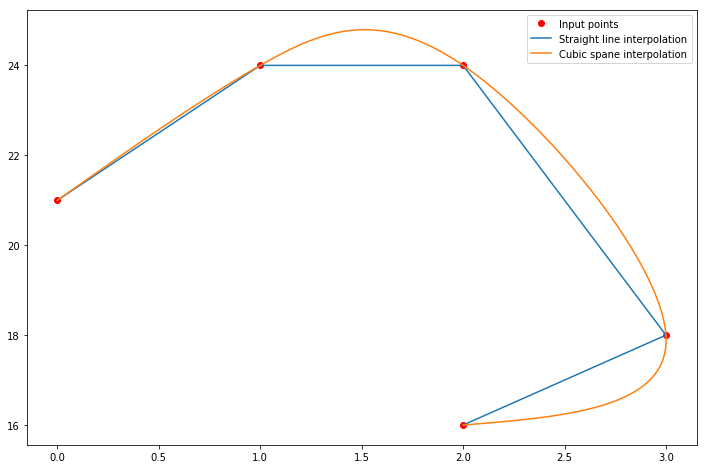

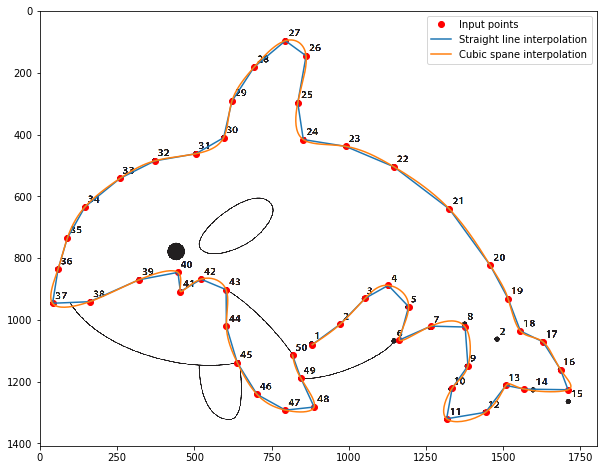

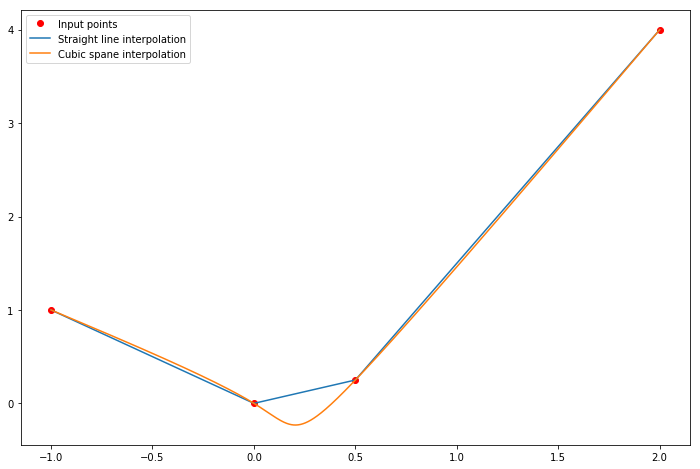

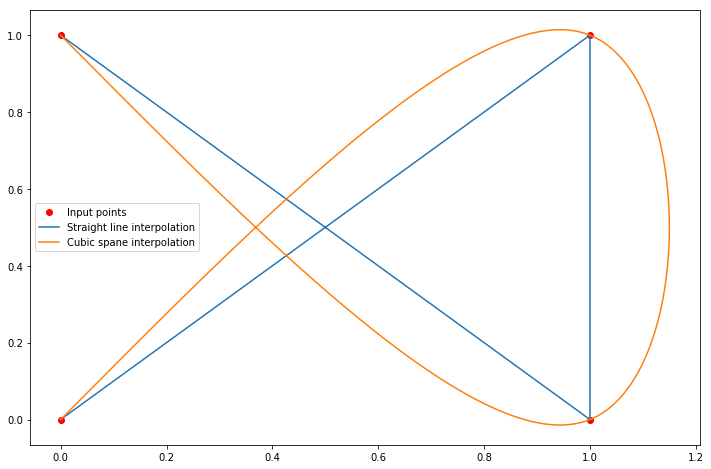

In [34]:
STRAIGHT_LINE_INTERPOLATION = {'function': straight_linear_interpolation_2d, 'name': 'Straight line interpolation'}
CUBIC_SPANE_INTERPOLATION = {'function': cubic_spane_interpolation, 'name': 'Cubic spane interpolation'}

show_interpolation_results(sample_points, [STRAIGHT_LINE_INTERPOLATION, CUBIC_SPANE_INTERPOLATION])
show_interpolation_results(dolphin_points, [STRAIGHT_LINE_INTERPOLATION, CUBIC_SPANE_INTERPOLATION], template_filename='dots.png')
show_interpolation_results(first_example, [STRAIGHT_LINE_INTERPOLATION, CUBIC_SPANE_INTERPOLATION])
show_interpolation_results(second_example, [STRAIGHT_LINE_INTERPOLATION, CUBIC_SPANE_INTERPOLATION])